# **Optimizing Partial AUC Loss on Imbalanaced Dataset (tpAUC-KL)**

**Author**: Dixian Zhu  
**Edited by**: Zhuoning Yuan
 

**Introduction**

In this tutorial, we will learn how to quickly train a ResNet18 model by optimizing **two way partial AUC** score using our novel **`SOTA-s`** method on an binary image classification task on Cifar10. After completion of this tutorial, you should be able to use LibAUC to train your own models on your own datasets.

**References**

If you find this tutorial helpful in your work,  please acknowledge our library and cite the following papers:

<pre>
@article{zhu2022auc,
  title={When AUC meets DRO: Optimizing Partial AUC for Deep Learning with Non-Convex Convergence Guarantee},
  author={Zhu, Dixian and Li, Gang and Wang, Bokun and Wu, Xiaodong and Yang, Tianbao},
  journal={arXiv preprint arXiv:2203.00176},
  year={2022}
}

@misc{libauc2022,
	title={LibAUC: A Deep Learning Library for X-risk Optimization.},
	author={Zhuoning Yuan, Zi-Hao Qiu, Gang Li, Dixian Zhu, Zhishuai Guo, Quanqi Hu, Bokun Wang, Qi Qi, Yongjian Zhong, Tianbao Yang},
	year={2022}
	}
</pre>

## **Installing LibAUC**

Let's start with install our library here. In this tutorial, we will use beta version `1.1.9rc4`.

In [ ]:
!pip install libauc==1.1.9rc4

## **Importing LibAUC**

Import required libraries to use




In [ ]:
from libauc.models import resnet18
from libauc.datasets import CIFAR10
from libauc.losses.auc import tpAUC_KL_Loss
from libauc.optimizers import SOTAs
from libauc.utils import ImbalancedDataGenerator
from libauc.sampler import DualSampler
from libauc.metrics import pauc_roc_score

import torch 
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings("ignore")

## **Reproducibility**

These functions limit the number of sources of randomness behaviors, such as model intialization, data shuffling, etcs. However, completely reproducible results are not guaranteed across PyTorch releases [[Ref]](https://pytorch.org/docs/stable/notes/randomness.html#:~:text=Completely%20reproducible%20results%20are%20not,even%20when%20using%20identical%20seeds.).

In [ ]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## **Image Dataset**


Now that we defined the data input pipeline such as data augmentations. In this tutorials, we use `RandomCrop`, `RandomHorizontalFlip`. The `pos_index_map` helps map global index to local index for reducing memory cost in loss function since we only need to track the indices for positive samples. Please refer to original paper [here](https://arxiv.org/pdf/2203.00176.pdf) for more details.




In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, image_size=32, crop_size=30, mode='train'):
       self.images = images.astype(np.uint8)
       self.targets = targets
       self.mode = mode
       self.transform_train = transforms.Compose([                                                
                              transforms.ToTensor(),
                              transforms.RandomCrop((crop_size, crop_size), padding=None),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize((image_size, image_size)),
                              ])
       self.transform_test = transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Resize((image_size, image_size)),
                              ])
       
       # for loss function
       self.pos_indices = np.flatnonzero(targets==1)
       self.pos_index_map = {}
       for i, idx in enumerate(self.pos_indices):
           self.pos_index_map[idx] = i

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            idx = self.pos_index_map[idx] if idx in self.pos_indices else -1
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target, idx

## **Introduction for Loss and Optimizer**

In this section, we will introduce pAUC optimization algorithm and how to utilize `tpAUC_KL_Loss` function and `SOTAs` optimizer.  

### **tpAUC KL**  
Different with conventional AUROC (area under roc curve), two-way partial AUC aims to maximize the specific region under ROC curve, i.e. FPR is upper bounded by $\beta$ and TPR is lower bounded by $\alpha$. The objective function for **SOTA-s** method is:
\begin{align*}
F(\mathbf w; \phi, \phi')=\max_{\mathbf p\in\Delta}\sum_{\mathbf x_i\in\mathcal S_+} p_i \hat L_\phi(\mathbf x_i, \mathbf w)  -  \lambda' D_{\phi'}(\mathbf p, \frac{1}{n_+}).
\end{align*}
where $\hat L_\phi(\mathbf x_i, \mathbf w)$ represents the one-way partial AUC estimator for $\mathbf x_i$ vesus all negative samples. For more details, please refer to: https://arxiv.org/abs/2203.00176, section 5.



The SOTA-s algorithm is summarized as follows, denote $\mathcal S_+$ and $\mathcal S_-$ as postive and negative training data:

Set $\mathbf u_0=0, v_0=0, \mathbf m_0=0$ and initialize $\mathbf w$
For {$t = 1,\ldots, T$}
1. Sample two mini-batches $\mathcal B_+\subset\mathcal S_+$, $\mathcal B_-\subset\mathcal S_-$ 
2. For each $\mathbf x_i\in\mathcal B_{+}$ compute $u^i_{t} =(1-\gamma_0)u^i_{t-1} + \gamma_0 \frac{1}{|B_-|}  \sum_{\mathbf x_j\in \mathcal B_-}L(\mathbf w_t; \mathbf x_i, \mathbf x_j) $
3. Let $v_{t} = (1-\gamma_1)v_{t-1} + \gamma_1\frac{1}{|\mathcal B_{+}|}\sum_{\mathbf x_i\in \mathcal B_{+}} f_2(u^i_{t-1})$
4. Let $p_{ij} = (u^i_{t-1})^{\lambda/\lambda' - 1}\exp (L(\mathbf w_t, \mathbf x_i, \mathbf x_j)/\lambda)/v_{t}$
5. Compute a gradient estimator $\nabla_t$ by $$\nabla_t=\frac{1}{|\mathcal B_{+}}\frac{1}{|\mathcal B_-|}\sum_{\mathbf x_i\in\mathcal B_{+}}   \sum_{\mathbf x_j\in \mathcal B_-}p_{ij}\nabla L(\mathbf w_t; \mathcal x_i, \mathcal x_j)$$
6. Update $\mathbf m_{t}=(1-\beta_2)\mathbf m_{t-1} + \beta_2 \nabla_t$
7. Update $\mathbf w_{t+1}   =\mathbf w_t - \eta_1  \mathbf m_t$   (or Adam-style)



### **Hyper-parameters**

**Sampler**:
- `sampling_rate`: the oversampling ratio for the positive minority class. 0.5 is usually good value for imbalanced data.

**Loss**:
- `pos_len`: the size of positive samples in training set.
- `Lambda`: KL-DRO regularization for inner negative samples part (that is, $\lambda$ in the algorithm). It is critical to be tuned approprately based on the task.
- `tau`: KL-DRO regularization for outer positive samples part (that is, $\lambda'$ in the algorithm). It is critical to be tuned approprately based on the task.

**Optimizer**:
- `weight_decay`: weight decay for the model parameters. Might be tuned in practice.
- `lr`: the learning rate used for SOPA algorithm; it is $\eta_1$ in the SOPA algorithm. Suggest to be tuned in practice.
- `gamma0`: the step size for update $u^i_{t}$ that controls negative samples weights. Suggest to be tuned in practice.
- `gamma1`: the step size for update $v_{t}$ that controls positive samples weights. Suggest to be tuned in practice.
- `mode`: select Adam-style or SGD-style to update model's parameters. Choose from `sgd`, `adam`

### **Some Tips**:
- Sensitive parameters to tune: **`Lambda`, `tau`, `gamma0`, `gamma1`, `lr`**.
- Non-sensitive parameters might be fixed: `sampling_rate`=0.5.
- Might be tuned based on different tasks: `weight_decay`, `total_epochs`, `decay_epochs`, `decaY_factor`.




In [ ]:
# paramaters
SEED = 123
batch_size = 64
total_epochs = 60
weight_decay = 1e-4
lr = 1e-3 
decay_epochs = [20, 40]
decay_factor = 10

gamma0 = 0.5 # learning rate for control negative samples weights
gamma1 = 0.5 # learning rate for control positive samples weights

tau = 1.0 # KL-DRO regularization for outer positive samples part  # 
Lambda = 0.5 # KL-DRO regularization for inner negative samples part # 

sampling_rate = 0.5 
num_pos = round(sampling_rate*batch_size) 
num_neg = batch_size - num_pos

## **Load Data, Preprocessing, and data loader**

In this step, we will use the [CIFAR10](http://yann.lecun.com/exdb/mnist/) as benchmark dataset. Before importing data to `dataloader`, we construct imbalanced version for CIFAR10 by `ImbalanceDataGenerator`. Specifically, it first randomly splits the training data by class ID (e.g., 10 classes) into two even portions as the positive and negative classes, and then it randomly removes some samples from the positive class to make
it imbalanced. We keep the testing set untouched. We refer `imratio` to the ratio of number of positive examples to number of all examples. 

In [ ]:
train_data, train_targets = CIFAR10(root='./data', train=True)
test_data, test_targets  = CIFAR10(root='./data', train=False)

imratio = 0.2
g = ImbalancedDataGenerator(shuffle=True, verbose=True, random_seed=0)
(train_images, train_labels) = g.transform(train_data, train_targets, imratio=imratio)
(test_images, test_labels) = g.transform(test_data, test_targets, imratio=0.5) 

traindSet = ImageDataset(train_images, train_labels)
testSet = ImageDataset(test_images, test_labels, mode = 'test')
sampler = DualSampler(dataset=traindSet, batch_size=batch_size, shuffle=True, sampling_rate=sampling_rate)
trainloader =  torch.utils.data.DataLoader(traindSet, sampler=sampler, batch_size=batch_size, shuffle=False, num_workers=1)   
testloader =  torch.utils.data.DataLoader(testSet, batch_size=32, num_workers=2, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
#SAMPLES: [31250], POS:NEG: [6250 : 25000], POS RATIO: 0.2000
#SAMPLES: [10000], POS:NEG: [5000 : 5000], POS RATIO: 0.5000


## **Model and Loss setup**

In [ ]:
set_all_seeds(SEED)
model = resnet18(pretrained=False, num_classes=1, last_activation=None)
model = model.cuda() 

loss_fn = tpAUC_KL_Loss(pos_len=sampler.pos_len, Lambda=Lambda, tau=tau)
optimizer = SOTAs(model, loss_fn=loss_fn, mode='adam', lr=lr, gammas=(gamma0, gamma1), weight_decay=weight_decay) 

## **Training**

In [ ]:
print ('Start Training')
print ('-'*30)

tr_tpAUC=[]
te_tpAUC=[]

for epoch in range(total_epochs):
    if epoch in decay_epochs:
        optimizer.update_lr(decay_factor=decay_factor, coef_decay_factor=decay_factor)
 
    train_loss = 0
    model.train()
    for idx, data in enumerate(trainloader):
        train_data, train_labels, index = data
        train_data, train_labels = train_data.cuda(), train_labels.cuda()
        y_pred = model(train_data)
        y_prob = torch.sigmoid(y_pred)
        loss = loss_fn(y_prob, train_labels, index[:num_pos])
        train_loss = train_loss  + loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/(idx+1)
   
    # evaluation
    model.eval()
    with torch.no_grad():    
        train_pred = []
        train_true = []
        for jdx, data in enumerate(trainloader):
            train_data, train_labels,_ = data
            train_data = train_data.cuda()
            y_pred = model(train_data)    
            y_prob = torch.sigmoid(y_pred)
            train_pred.append(y_prob.cpu().detach().numpy())
            train_true.append(train_labels.numpy())
        train_true = np.concatenate(train_true)
        train_pred = np.concatenate(train_pred)
        single_train_auc =  pauc_roc_score(train_true, train_pred, max_fpr = 0.3, min_tpr=0.7) 

        test_pred = []
        test_true = [] 
        for jdx, data in enumerate(testloader):
            test_data, test_labels, _ = data
            test_data = test_data.cuda()
            y_pred = model(test_data)    
            y_prob = torch.sigmoid(y_pred)
            test_pred.append(y_prob.cpu().detach().numpy())
            test_true.append(test_labels.numpy())
        test_true = np.concatenate(test_true)
        test_pred = np.concatenate(test_pred)
        single_test_auc =  pauc_roc_score(test_true, test_pred, max_fpr = 0.3, min_tpr=0.7) 
        print('Epoch=%s, Loss=%0.4f, Train_tpAUC(0.3,0.7)=%.4f, Test_tpAUC(0.3,0.7)=%.4f, lr=%.4f'%(epoch, train_loss, single_train_auc, single_test_auc, optimizer.lr))
        
        tr_tpAUC.append(single_train_auc)
        te_tpAUC.append(single_test_auc)

Start Training
------------------------------
Epoch=0, Loss=1.3605, Train_tpAUC(0.3,0.7)=0.0000, Test_tpAUC(0.3,0.7)=0.0000, lr=0.0010
Epoch=1, Loss=0.9254, Train_tpAUC(0.3,0.7)=0.0071, Test_tpAUC(0.3,0.7)=0.0002, lr=0.0010
Epoch=2, Loss=0.8980, Train_tpAUC(0.3,0.7)=0.1079, Test_tpAUC(0.3,0.7)=0.0603, lr=0.0010
Epoch=3, Loss=0.8715, Train_tpAUC(0.3,0.7)=0.1582, Test_tpAUC(0.3,0.7)=0.1110, lr=0.0010
Epoch=4, Loss=0.8409, Train_tpAUC(0.3,0.7)=0.1825, Test_tpAUC(0.3,0.7)=0.1001, lr=0.0010
Epoch=5, Loss=0.8128, Train_tpAUC(0.3,0.7)=0.2420, Test_tpAUC(0.3,0.7)=0.1054, lr=0.0010
Epoch=6, Loss=0.7757, Train_tpAUC(0.3,0.7)=0.1679, Test_tpAUC(0.3,0.7)=0.1350, lr=0.0010
Epoch=7, Loss=0.7477, Train_tpAUC(0.3,0.7)=0.3339, Test_tpAUC(0.3,0.7)=0.1707, lr=0.0010
Epoch=8, Loss=0.7154, Train_tpAUC(0.3,0.7)=0.2408, Test_tpAUC(0.3,0.7)=0.1188, lr=0.0010
Epoch=9, Loss=0.6689, Train_tpAUC(0.3,0.7)=0.5289, Test_tpAUC(0.3,0.7)=0.2403, lr=0.0010
Epoch=10, Loss=0.6385, Train_tpAUC(0.3,0.7)=0.4619, Test_tpAUC(0

# **Visualization**

Now, let's see the change of two-way partial AUC scores on training and testing set. We take the `AUC-M` method as a comparison. For more details and tutorials about `AUCM Loss`, please refer to [AUC-M](https://github.com/Optimization-AI/LibAUC/blob/main/examples/02_Optimizing_AUROC_with_ResNet20_on_Imbalanced_CIFAR10.ipynb).



Text(0.5, 0, 'epochs')

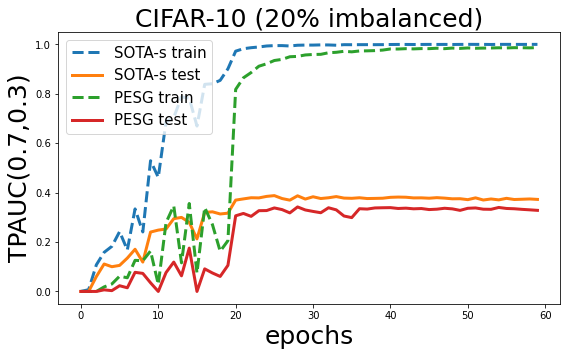

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9,5)
x=np.arange(60)
aucm_tr_tpAUC = [0.0, 0.0036274632780175535, 0.005047971892709222, 0.16224877002854712, 0.08772204107278256, 0.09231572626711304, 0.2732654643710093, 0.26647582593555136, 0.24948327111467297, 0.3138958243403896, 0.41470878408333095, 0.43854233806173326, 0.44279415206018125, 0.41232459713094294, 0.42158369465786594, 0.28455608967939594, 0.47755676075725645, 0.4896781046120168, 0.3863189337375359, 0.41758365936793596, 0.842293465507402, 0.8849664436167597, 0.908744785930645, 0.925100663457797, 0.9326945885667315, 0.9383691079068582, 0.9493701298918441, 0.953469756067609, 0.959401363614275, 0.9611639035102166, 0.9687268876750703, 0.96784177567828, 0.9702642497143897, 0.9702752956047458, 0.9733664551144465, 0.9760006331554156, 0.9760579703978677, 0.9755799377033129, 0.9770459817114208, 0.9787550086264667, 0.9813317160205113, 0.9802740408912104, 0.9814502948096553, 0.9811205278462805, 0.9821393644867049, 0.9823378881296415, 0.9827693626631546, 0.9815768245053843, 0.9835002857701681, 0.9825182242961066, 0.9819347131316462, 0.9819089304938505, 0.9819178330190087, 0.9830069649230193, 0.982775401438961, 0.9835906895346361, 0.9843369096878757, 0.9844427527966737, 0.9829346774859711, 0.9838700118199921]
aucm_te_tpAUC = [0.0, 0.000301777777777778, 0.0, 0.050526666666666664, 0.022042666666666665, 0.006600444444444444, 0.09903022222222221, 0.10774866666666666, 0.1029888888888889, 0.08559822222222221, 0.17839955555555553, 0.16736266666666666, 0.1591968888888889, 0.14970355555555553, 0.16401288888888887, 0.10874133333333333, 0.2060488888888889, 0.20340622222222224, 0.15917866666666666, 0.15321466666666667, 0.3240817777777778, 0.3328191111111111, 0.33990511111111105, 0.33390533333333333, 0.3470675555555556, 0.3300217777777778, 0.35229422222222223, 0.32868844444444445, 0.34444044444444444, 0.33212177777777785, 0.3557311111111111, 0.33471155555555554, 0.332584, 0.3388742222222223, 0.31508044444444444, 0.3285328888888889, 0.32913555555555557, 0.35162800000000005, 0.32234244444444443, 0.31436844444444445, 0.331578888888889, 0.3387742222222222, 0.3338368888888889, 0.3277377777777778, 0.335048, 0.3345755555555555, 0.34122044444444444, 0.3344044444444444, 0.33397066666666664, 0.32639111111111113, 0.3255946666666667, 0.3287395555555556, 0.3287168888888889, 0.33072799999999997, 0.3306648888888889, 0.33826266666666666, 0.3271982222222222, 0.3275493333333333, 0.33227422222222225, 0.33158488888888893]
plt.figure()
plt.plot(x, tr_tpAUC, LineStyle='--', label='SOTA-s train', linewidth=3)
plt.plot(x, te_tpAUC, label='SOTA-s test', linewidth=3)
plt.plot(x, aucm_tr_tpAUC, LineStyle='--', label='PESG train', linewidth=3)
plt.plot(x, aucm_te_tpAUC, label='PESG test', linewidth=3)
plt.title('CIFAR-10 (20% imbalanced)',fontsize=25)
plt.legend(fontsize=15)
plt.ylabel('TPAUC(0.7,0.3)',fontsize=25)
plt.xlabel('epochs',fontsize=25)